In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
import torch
import math
import os
from PIL import Image
import numpy as np
import json

In [2]:
# Define transformations for images and masks
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the input images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the masks to match images
    transforms.ToTensor(),  # Convert masks to PyTorch tensors
])

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, image_transforms=None, mask_transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.images = []

        # Filter for image files and ensure corresponding masks exist
        valid_extensions = ['.jpg', '.jpeg', '.png']  # Add or remove extensions as needed
        self.images = [f for f in os.listdir(image_dir) 
                       if any(f.endswith(ext) for ext in valid_extensions)
                       and os.path.exists(os.path.join(mask_dir, f"binary_{f}"))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_filename = self.images[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        mask_filename = f"binary_{img_filename}"  # Adjust based on your mask naming convention
        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transforms:
            image = self.image_transforms(image)
        if self.mask_transforms:
            mask = self.mask_transforms(mask)

        return image, mask


In [3]:
class DoubleConv(nn.Module):
    """(Convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [4]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float("inf")
        
    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (validation_loss + self.min_delta):
            self.counter += 1
            if self.counter > self.patience:
                return True
        return False

In [5]:
class UNetPlusPlus(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNetPlusPlus, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        filters = [64, 128, 256, 512, 1024]

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) if bilinear else nn.ConvTranspose2d(filters[1], filters[1] // 2, kernel_size=2, stride=2)

        # Create the convolutional blocks for the expanding path and contracting path
        self.conv0_0 = DoubleConv(n_channels, filters[0])
        self.conv1_0 = DoubleConv(filters[0], filters[1])
        self.conv2_0 = DoubleConv(filters[1], filters[2])
        self.conv3_0 = DoubleConv(filters[2], filters[3])
        self.conv4_0 = DoubleConv(filters[3], filters[4])  # Bottom of the U shape

        # Creating convolutional blocks that are one step away from the main down path
        self.conv0_1 = DoubleConv(filters[0] + filters[1], filters[0])
        self.conv1_1 = DoubleConv(filters[1] + filters[2], filters[1])
        self.conv2_1 = DoubleConv(filters[2] + filters[3], filters[2])
        self.conv3_1 = DoubleConv(filters[3] + filters[4], filters[3])

        # Creating convolutional blocks that are two steps away from the main down path
        self.conv0_2 = DoubleConv(filters[0]*2 + filters[1], filters[0])
        self.conv1_2 = DoubleConv(filters[1]*2 + filters[2], filters[1])
        self.conv2_2 = DoubleConv(filters[2]*2 + filters[3], filters[2])

        # Creating convolutional blocks that are three steps away from the main down path
        self.conv0_3 = DoubleConv(filters[0]*3 + filters[1], filters[0])
        self.conv1_3 = DoubleConv(filters[1]*3 + filters[2], filters[1])

        # Creating convolutional blocks that are four steps away from the main down path
        self.conv0_4 = DoubleConv(filters[0]*4 + filters[1], filters[0])

        self.final_conv = nn.Conv2d(filters[0], n_classes, kernel_size=1)

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        output = self.final_conv(x0_4)
        return output


In [6]:
# Hyperparameters
learning_rate = 1e-4
batch_size = 1
num_epochs = 10

# Load the full dataset
image_dir = '/Users/lionel/Desktop/Research/Original_cropped_size'
mask_dir = '/Users/lionel/Desktop/Research/Masked_cropped'
full_dataset = SegmentationDataset(image_dir, mask_dir, image_transforms, mask_transforms)

# Split the dataset
total_size = len(full_dataset)
print(total_size)
val_size = int(0.3 * total_size)  # Calculate 30% of the total size for validation
train_size = total_size - val_size  # The rest for training
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Prepare data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, optimizer, and loss function
model = UNetPlusPlus(n_channels=3, n_classes=1).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = BCEWithLogitsLoss()

# Initialize performance metrics
losses = []
accuracies = []
val_losses = []
val_accs = []

# Initialize earlystopper
early_stopper = EarlyStopping(patience=1, min_delta=0)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    correct_pixels = 0
    total_pixels = 0

    for images, masks in train_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        total_loss += loss.item()

        # Calculating accuracy
        predicted = torch.sigmoid(outputs) > 0.5  # Convert output probabilities to binary predictions (0 or 1)
        correct_pixels += (predicted == masks).sum().item()
        total_pixels += torch.numel(masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / len(train_dataloader)
    epoch_acc = correct_pixels / total_pixels * 100

    # Append metrics to lists
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    # Validate the results
    val_total_loss = 0
    val_correct_pixels = 0
    val_total_pixels = 0
    with torch.no_grad():
        for val_images, val_masks in val_dataloader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
    
            # Forward pass
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_masks)
            val_total_loss += val_loss.item()
    
            # Calculating accuracy
            val_predicted = torch.sigmoid(val_outputs) > 0.5  # Convert output probabilities to binary predictions (0 or 1)
            val_correct_pixels += (val_predicted == val_masks).sum().item()
            val_total_pixels += torch.numel(val_masks)
    
        val_epoch_loss = val_total_loss / len(val_dataloader)
        val_epoch_acc = val_correct_pixels / val_total_pixels * 100
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, val_Loss: {val_epoch_loss:.4f}, val_acc: {val_epoch_acc:.2f}%")

    if early_stopper.early_stop(val_epoch_loss):
        print(f"early stopped at epoch {epoch+1}")
        break
# Saving the metrics
output_dir = "/Users/lionel/Desktop/Research/"
metrics = {"loss": losses, "accuracy": accuracies}
metrics_path = 'U_Net_plus_plus_performance_metrics.json'
metrics_dir = os.path.join(output_dir, metrics_path)
with open(metrics_dir, 'w') as f:
    json.dump(metrics, f)  

    
# Save model and optimizer
model_path = 'Unet++_path_to_save_model.pth' # Change your path and path name accordingly
model_path = os.path.join(output_dir, model_path)
optimizer_path = 'Unet++_path_to_save_optimizer.pth' # Change your path and path name accordingly
optimizer_path = os.path.join(output_dir, optimizer_path)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_path)

# Optionally, save optimizer separately if needed
torch.save(optimizer.state_dict(), optimizer_path)

463
Epoch [1/10], Loss: 0.2386, Accuracy: 90.35%, val_Loss: 0.1657, val_acc: 93.71%
Epoch [2/10], Loss: 0.1473, Accuracy: 93.93%, val_Loss: 0.1212, val_acc: 94.82%
Epoch [3/10], Loss: 0.1223, Accuracy: 94.53%, val_Loss: 0.1009, val_acc: 95.22%
Epoch [4/10], Loss: 0.0983, Accuracy: 95.17%, val_Loss: 0.0964, val_acc: 95.26%
Epoch [5/10], Loss: 0.0806, Accuracy: 95.73%, val_Loss: 0.0733, val_acc: 95.95%
Epoch [6/10], Loss: 0.0760, Accuracy: 95.80%, val_Loss: 0.0732, val_acc: 95.77%
Epoch [7/10], Loss: 0.0794, Accuracy: 95.64%, val_Loss: 0.0621, val_acc: 96.14%
Epoch [8/10], Loss: 0.0591, Accuracy: 96.33%, val_Loss: 0.0617, val_acc: 96.16%
Epoch [9/10], Loss: 0.0558, Accuracy: 96.39%, val_Loss: 0.0570, val_acc: 96.31%
Epoch [10/10], Loss: 0.0582, Accuracy: 96.25%, val_Loss: 0.0654, val_acc: 95.89%


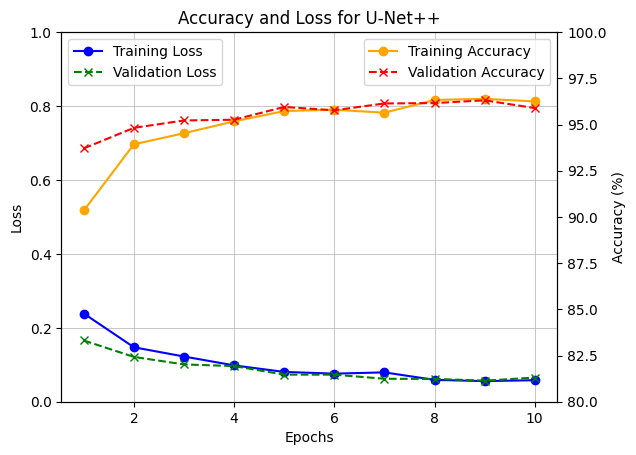

"\nplt.figure(figsize=(6, 4))\nplt.plot(epoch, training_losses, label='Training Loss', marker='o')\nplt.plot(epoch, training_accuracies, label='Training Accuracy', marker='o')\nplt.plot(epochs, validation_losses, label='Validation Loss', linestyle='--', marker='x')\nplt.plot(epochs, validation_accuracies, label='Validation Accuracy', linestyle='--', marker='x')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy and Loss')\nplt.title('Accuracy and Loss for U-Net++')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [5]:
import matplotlib.pyplot as plt
import matplotlib
# Epochs
epoch = list(range(1, 11))

# Training loss
training_losses = [0.2386, 0.1473, 0.1223, 0.0983, 0.0806, 0.0760, 0.0794, 0.0591, 0.0558, 0.0582]

# Training accuracy (converted to scale from 0 to 1)
training_accuracies = [90.35, 93.93, 94.53, 95.17, 95.73, 95.80, 95.64, 96.33, 96.39, 96.25]
#training_accuracies = [x / 100 for x in training_accuracies]

# Validation loss
validation_losses = [0.1657, 0.1212, 0.1009, 0.0964, 0.0733, 0.0732, 0.0621, 0.0617, 0.0570, 0.0654]

# Validation accuracy (converted to scale from 0 to 1)
validation_accuracies = [93.71, 94.82, 95.22, 95.26, 95.95, 95.77, 96.14, 96.16, 96.31, 95.89]
#validation_accuracies = [x / 100 for x in validation_accuracies]

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot training and validation loss on the primary y-axis
ax1.plot(epoch, training_losses, color ='blue', label='Training Loss', marker='o')
ax1.plot(epoch, validation_losses, color ='green', label='Validation Loss', linestyle='--', marker='x')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_ylim([0, 1])  # Setting the limit for loss
ax1.legend(loc='upper left')

# Create a second y-axis for the accuracies
ax2 = ax1.twinx()
ax2.plot(epoch, training_accuracies, color ='orange', label='Training Accuracy', marker='o')
ax2.plot(epoch, validation_accuracies, color ='red', label='Validation Accuracy', linestyle='--', marker='x')
ax2.set_ylabel('Accuracy (%)')
ax2.set_ylim([80, 100])  # Setting the limit for accuracy
ax2.legend(loc='upper right')


# Show the plot
plt.title('Accuracy and Loss for U-Net++')
ax1.grid(True, which='both', axis='both', linestyle='-', linewidth=0.5)
plt.show()
"""
plt.figure(figsize=(6, 4))
plt.plot(epoch, training_losses, label='Training Loss', marker='o')
plt.plot(epoch, training_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_losses, label='Validation Loss', linestyle='--', marker='x')
plt.plot(epochs, validation_accuracies, label='Validation Accuracy', linestyle='--', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Loss')
plt.title('Accuracy and Loss for U-Net++')
plt.legend()
plt.grid(True)
plt.show()
"""

In [8]:
import torch

def evaluate_model(dataloader, model, device, threshold=0.5):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Initialize counters
    TP = 0
    FP = 0
    FN = 0
    TN = 0

    with torch.no_grad():
        for images, true_masks in dataloader:
            images = images.to(device)
            true_masks = true_masks.to(device)
            
            # Obtain the model's logits for each image
            logits = model(images)
            
            # Apply sigmoid to convert logits to probabilities
            probs = torch.sigmoid(logits)
            
            # Apply threshold to obtain binary predictions
            preds = probs > threshold
            
            # Flatten the predictions and true values for easier comparison
            preds, true_masks = preds.view(-1), true_masks.view(-1)
            
            # Calculate TP, FP, FN, TN
            TP += ((preds == 1) & (true_masks == 1)).sum().item()
            FP += ((preds == 1) & (true_masks == 0)).sum().item()
            FN += ((preds == 0) & (true_masks == 1)).sum().item()
            TN += ((preds == 0) & (true_masks == 0)).sum().item()

    # Return the confusion matrix components
    return TP, FP, FN, TN


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluate on training data
TP_train, FP_train, FN_train, TN_train = evaluate_model(train_dataloader, model, device)
print(f"Training Data - TP: {TP_train}, FP: {FP_train}, FN: {FN_train}, TN: {TN_train}")

# Evaluate on validation data
TP_val, FP_val, FN_val, TN_val = evaluate_model(val_dataloader, model, device)
print(f"Validation Data - TP: {TP_val}, FP: {FP_val}, FN: {FN_val}, TN: {TN_val}")


Training Data - TP: 11784494, FP: 244079, FN: 518069, TN: 8192763
Validation Data - TP: 4833672, FP: 82150, FN: 244880, TN: 3646578


In [10]:
def calculate_performance_metrics(TP, FP, FN, TN):
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) else 0
    dice_coefficient = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0
    jaccard_index = TP / (TP + FP + FN) if (TP + FP + FN) else 0
    
    return precision, recall, accuracy, dice_coefficient, jaccard_index


precision, recall, accuracy, dice_coefficient, jaccard_index = calculate_performance_metrics(TP_val, FP_val, FN_val, TN_val)

print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Dice Coefficient (F1 Score): {dice_coefficient*100:.2f}%")
print(f"Jaccard Index (IoU): {jaccard_index*100:.2f}%")


Precision: 98.33%
Recall: 95.18%
Accuracy: 96.29%
Dice Coefficient (F1 Score): 96.73%
Jaccard Index (IoU): 93.66%


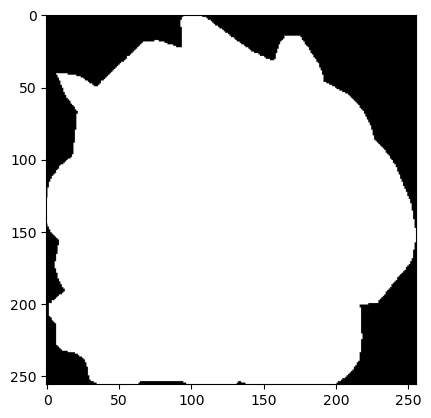

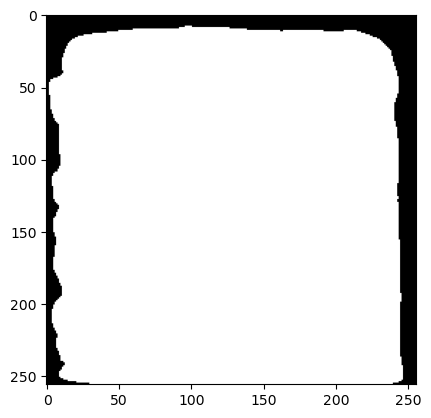

In [7]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# Load your image
image_path = "/Users/lionel/Desktop/Research/Original_cropped_size/T_rgb_20231216_194953_17.png"
mask_path = "/Users/lionel/Desktop/Research/Masked_cropped/binary_T_rgb_20231216_194953_17.png"
image = Image.open(image_path)
mask = Image.open(mask_path).resize((256,256))
plt.imshow(mask)
plt.show()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the input size expected by the model
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Apply transformations
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Assuming model is your pre-trained model
model.eval()  # Set the model to evaluation mode

# If using a GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
input_image = input_image.to(device)

with torch.no_grad():  # No need to track gradients
    output = model(input_image)
    mask = torch.sigmoid(output)  # Apply sigmoid to get probabilities
    mask = (mask > 0.5).float()  # Threshold the probabilities to get binary mask


# Move the mask to CPU and convert to a PIL image
mask = mask.squeeze().cpu()  # Remove batch dimension and move to CPU
mask_image = transforms.ToPILImage()(mask)

# Display the mask using matplotlib
import matplotlib.pyplot as plt

plt.imshow(mask_image, cmap='gray')  # Display the mask
#plt.axis('off')  # No axes for cleaner visualization
plt.show()

# Or save the mask to a file
mask_image.save('/Users/lionel/Desktop/Research/duplicate library/test/test5_unet++.png')
